# Assignment 1: Supervised Learning Tasks

In the lecture, we briefly discussed supervised and unsupervised learning in the context of machine learning. In this assignment, we will go through binary classification tasks on one of the most popular datasets in the fairness in machine learning literature.

We will:
1. Import the data, implement a few pre-processing steps, and inspect the data
2. Run a short exploratory analysis of the target variable
3. Train a binary classifier and evaluate the classifier using the predicted labels

# Packages and Modules

You may need to install the following packages:




In [1]:
# %pip install pandas numpy statsmodels matplotlib seaborn

In [2]:
# I'm using a conda environment, and these packages can be acquired using the following command:
# `conda install pandas numpy statsmodels matplotlib seaborn`

Import the packages and modules:


In [ ]:
import math
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import sklearn
import sklearn.model_selection
import sklearn.metrics
import sklearn.datasets
import sklearn.ensemble
import sklearn.preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline

from IPython.display import Markdown, display, Image
import matplotlib.pyplot as plt
import warnings

from IPython.core.display import HTML 
import operator
from collections import defaultdict

import json
from collections import OrderedDict

import numpy as np
import pandas as pd

np.random.seed(1)

### Step 1: Load Data

For this assignment, we will work with the German Credit dataset which has been provided with this notebook (the dataset can also be downloaded from the UCI ML repository). The dataset has demographic and financial information for about 1,000 individuals, and the task for this dataset is to predict whether an individual is a good credit risk or a bad credit risk. More information about the dataset can be found here: https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data.

Load the dataset and check the first few rows:

In [4]:
cols = ['status', 'duration', 'credit_hist', 'purpose', 'credit_amt', 'savings', 'employment',\
            'install_rate', 'personal_status', 'debtors', 'residence', 'property', 'age', 'install_plans',\
            'housing', 'num_credits', 'job', 'num_liable', 'telephone', 'foreign_worker', 'credit']

# path changed to suit local env
data_df = pd.read_table('german.data', names=cols, sep=" ", index_col=False)

y = data_df['credit']

print("Shape: ", data_df.shape)
data_df.head(5)

Shape:  (1000, 21)


,status,duration,credit_hist,purpose,credit_amt,savings,employment,install_rate,personal_status,debtors,...,property,age,install_plans,housing,num_credits,job,num_liable,telephone,foreign_worker,credit
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


### Step 2: Data preprocessing

For our analysis, we will preprocess the dataset to get additional columns and bucketize some columns with numeric data. In particular, we will do the following:
1. Create a new column "sex" that is derived from the column "personal_status". From the "personal_status" column, two values of sex can be derived: male and female (refer the data definition in the UCI ML repository to enumerate the column values of this column). Append the new column to the dataframe created above.
2. Bucketize (or, discretize) the "age" column according to a chosen threshold (say, 45). For individuals with age greater than or equal to the threshold, replace the value with "old", and those with age less than the threshold will have the value "young".

In [5]:
data_df['personal_status'].unique()

array(['A93', 'A92', 'A91', 'A94'], dtype=object)

There are four unique values here - the data dict on the website has this to say about each value:

| Value | Representation |
| --- | --- |
| A91 | male, divorced/separated |
| A92 | female, divorced/separated |
| A93 | male, single |
| A94 | male, married/widowed |
| A95 | female, single |

The easiest way to do this is create a dict mapping, then apply it to this column to transform it, or just create a new one.

According to the data dict, the value A92 can introduce bias, since it includes females who are either divorced, married, or separated - all three outcomes mean different things
Would consider keeping "divorced/separated" as one category, and then "married/widowed" as another, like the male representation.

In [6]:
# write code to create the "sex" column and append to the dataframe
sex_mapping = {"A91": "Male", "A92": "Female", "A93": "Male", "A94": "Male", "A95": "Female"}

data_df['sex'] = data_df['personal_status'].map(sex_mapping)

# print the first few rows

# I'm going to print two columns, the original and the mapped; to validate

data_df[['sex', 'personal_status']].head(10)

,sex,personal_status
0,Male,A93
1,Female,A92
2,Male,A93
3,Male,A93
4,Male,A93
5,Male,A93
6,Male,A93
7,Male,A93
8,Male,A91
9,Male,A94


In [7]:
# write code to replace the "age" column with discrete values
# This will overwrite the original values

data_df['age'] = np.where(data_df['age'] < 45, "Young", "Old")

# print the first few rows

data_df['age']

0        Old
1      Young
2        Old
3        Old
4        Old
       ...  
995    Young
996    Young
997    Young
998    Young
999    Young
Name: age, Length: 1000, dtype: object

### Step 3: Exploratory data analysis

Now that we have imported the data and prepared it for analysis, we will inspect it for further analysis. Let's start by observing the distribution of the target variable and the columns we created just now.

In [8]:
# check for nulls
data_df.isnull().sum() / len(data_df) * 100

status             0.0
duration           0.0
credit_hist        0.0
purpose            0.0
credit_amt         0.0
savings            0.0
employment         0.0
install_rate       0.0
personal_status    0.0
debtors            0.0
residence          0.0
property           0.0
age                0.0
install_plans      0.0
housing            0.0
num_credits        0.0
job                0.0
num_liable         0.0
telephone          0.0
foreign_worker     0.0
credit             0.0
sex                0.0
dtype: float64

d:\Anaconda\envs\MDL2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


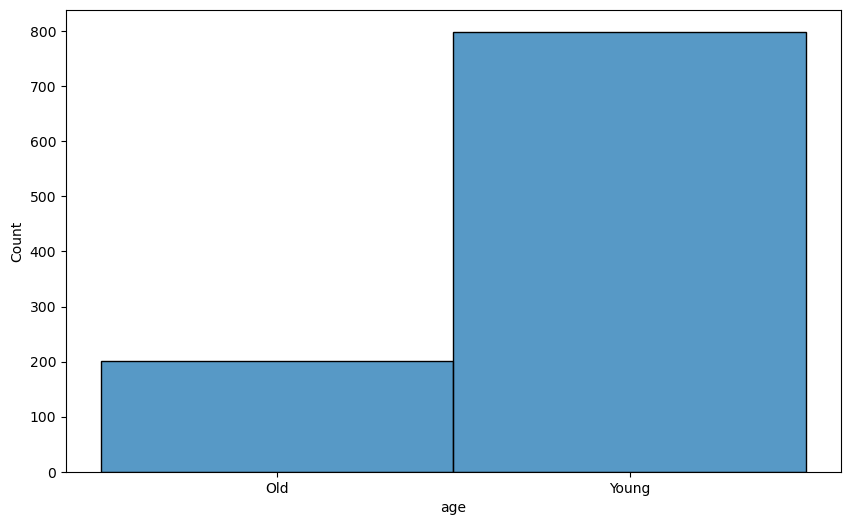

d:\Anaconda\envs\MDL2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


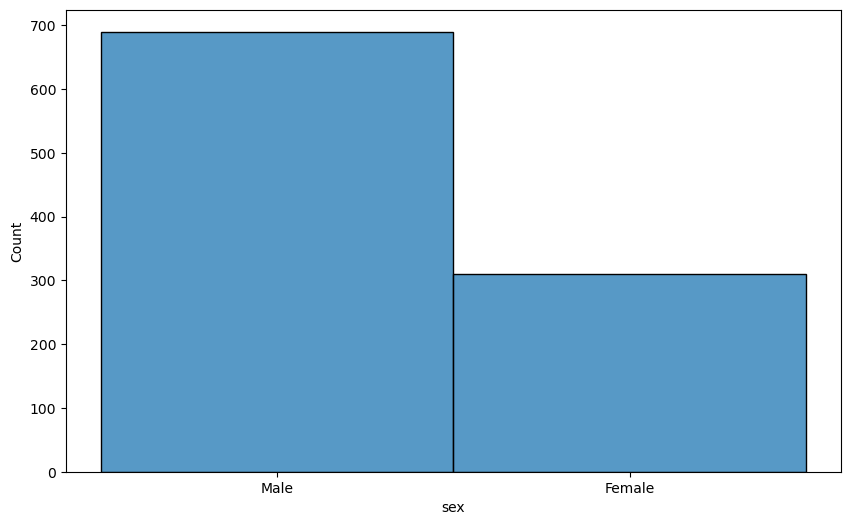

d:\Anaconda\envs\MDL2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


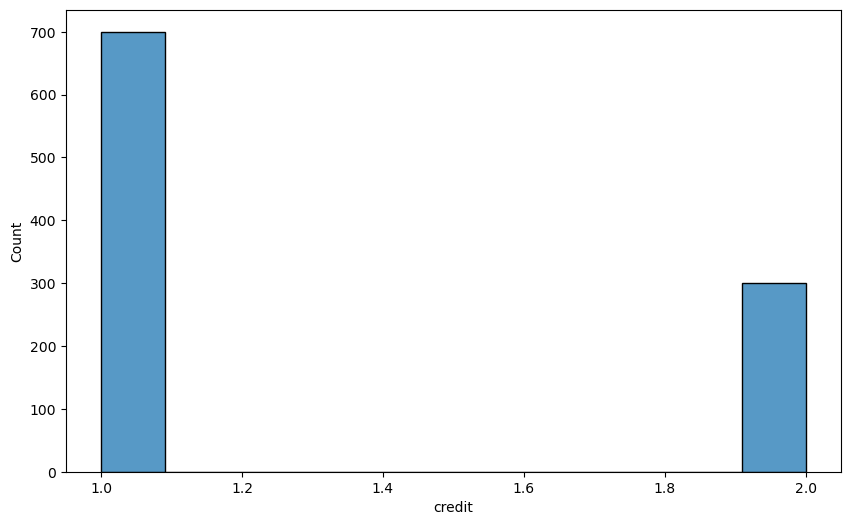

In [9]:
# write code to plot the distribution of age, sex, and credit
# in this code cell
cols = ['age', 'sex', 'credit']
for c in cols:
    plt.figure(figsize=(10,6))
    sns.histplot(data=data_df, x=c)
    plt.show()

# You may also plot the distribution of all the columns to better understand the data


# Observations

This is essentially telling us that there's a class imbalance.

1. There is more young people in this sample than there are old.
2. There are more "Male" samples than "Female"
3. There are more samples that are classified as "Good" than there are "Bad".

The good thing is that we have more than 30 datapoints, so we can apply the Central Limit Theorem. 

Let's consider the data distribution in terms of age and sex together: generate a crosstab summarizing the number of observations by age and sex:

In [10]:
# write code to generate a crosstab summarizing the number of observations by
# age and sex (i.e. a pivot table) in this code cell

crosstab_AgeSex = pd.crosstab(data_df['age'], data_df['sex'], margins=True)
print(crosstab_AgeSex)

sex    Female  Male   All
age                      
Old        49   152   201
Young     261   538   799
All       310   690  1000


# Observations

This is consistent with what we found in the previous task. There is an imbalance in the datapoints here:

1. There are, in general, more Males than Females across age categories.
2. There are significantly more datapoints for Young people (below the age of 45) than there are old.

Let's turn our focus to the primary variable of interest: credit risk. In this exploratory analysis, we are interested in the variable named "credit".

Plot the distribution of credit risk for males and for females.

d:\Anaconda\envs\MDL2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


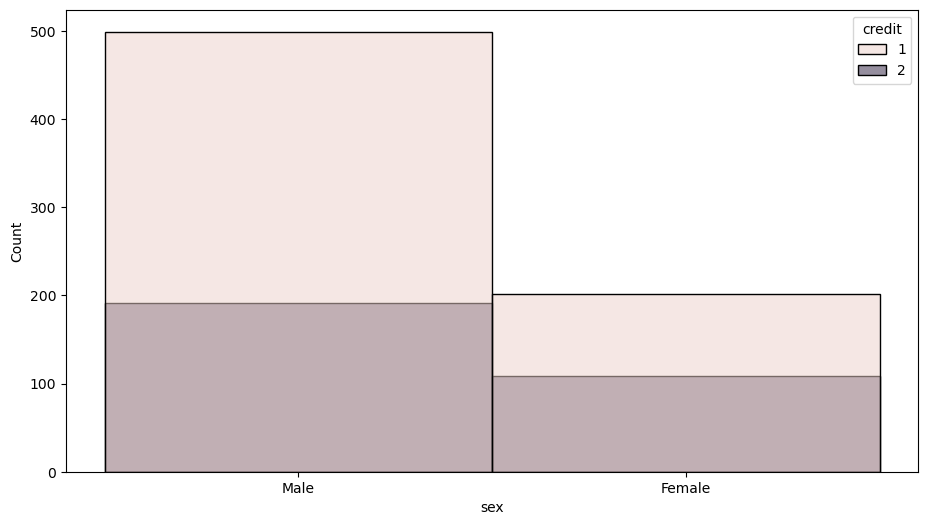

In [11]:
# plot credit risk by sex
plt.figure(figsize=(11,6))
sns.histplot(data=data_df, x="sex", hue="credit")
plt.show()

~~**TODO: To what extent do these distributions differ? Summarize the difference between the distribution of credit risks for male and female applicants in this text cell (three sentences maximum):**~~

Like we've seen in previous results, there is a significant differences in the number of males and females in this sample of data. Consequently, there are more Males with bad credit than there are females with bad credit, and there are more males with good credit than there are females with good credit; making the distribution more skewed toward male outcomes. Interestingly, the number of females with good and bad credit are similar; if not equal. 

What about age? Repeat the above plots for young and old applicants:

d:\Anaconda\envs\MDL2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


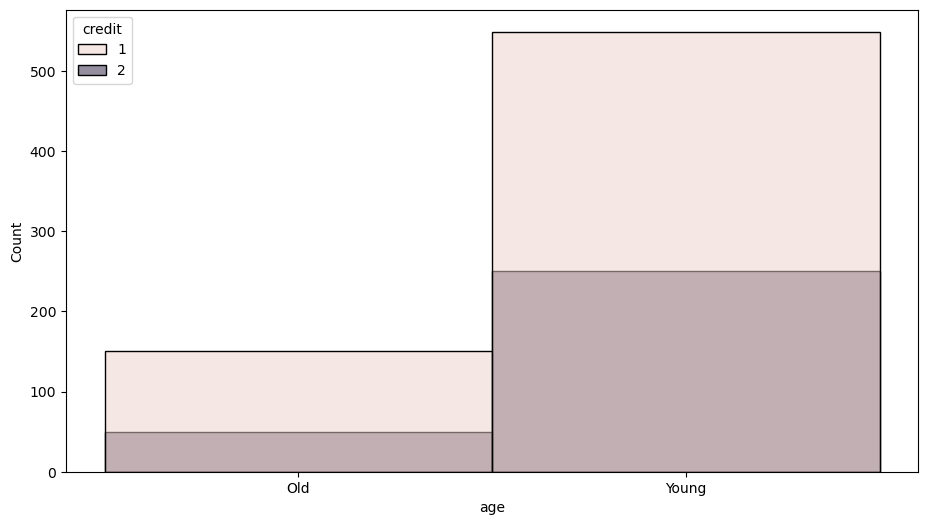

In [12]:
# write code to plot credit risk for young and old applicants in this code cell
plt.figure(figsize=(11,6))
sns.histplot(data=data_df, x="age", hue="credit")
plt.show()

~~**TODO: Summarize the difference between the distribution of credit risks for young and old applicants in this text cell (three sentences maximum):**~~

A significant portion of the data is skewed towards young adults rather than old adults, so we see a higher number of younger people with bad credit within this data sample. That being said, there is also a significant portion of young adults that have good credit. From the older adults sample, the number of old adults with bad credit is much lower than those with good credit, which indicates a lower credit risk amongst the older population than the young population. 

### Step 4: Train a classifier to predict credit using the original data

We will be training a logistic regression model to predict good/bad credit, then fine-tuning the model over a set of hyperparameters. For this purpose, we will use sklearn's logistic regression model. However, the model expects the data to be in numerical format. 

#### 4.1. Data preparation 
We have two options here:
1. Use sklearn's encoders to transform the categorical values into numerical values.
2. Write your own mapping functions (example for two of the columns has been provided below) with the best of your knowledge about the domain. Pay attention to columns with numerical data-- those could be bucketized or used as is. Similarly, column values in the categorical columns "purpose" and "housing" may not have a clear ordering-- in that case, you may consider creating dummy variables (be sure to drop the original columns).

Using either of the two techniques, prepare the data for the logistic regression model.

In [13]:
# I'm unsure if I should OHE or LE some columns, so I'm going to check how many uniques there are

for x in data_df.columns:
    print(f"Column {x} unique values:", data_df[x].nunique(), data_df[x].dtype)

Column status unique values: 4 object
Column duration unique values: 33 int64
Column credit_hist unique values: 5 object
Column purpose unique values: 10 object
Column credit_amt unique values: 921 int64
Column savings unique values: 5 object
Column employment unique values: 5 object
Column install_rate unique values: 4 int64
Column personal_status unique values: 4 object
Column debtors unique values: 3 object
Column residence unique values: 4 int64
Column property unique values: 4 object
Column age unique values: 2 object
Column install_plans unique values: 3 object
Column housing unique values: 3 object
Column num_credits unique values: 4 int64
Column job unique values: 4 object
Column num_liable unique values: 2 int64
Column telephone unique values: 2 object
Column foreign_worker unique values: 2 object
Column credit unique values: 2 int64
Column sex unique values: 2 object


In [ ]:
# write code to preprocess the data
# this function uses a pipeline with a single step; saves space on the notebook this way
# We're using two Encoders; Ordinal Encoder and One Hot Encoder, and one Scaler; the StandardScaler for numeric data
def preprocess(df):

    ord_columns = ['status', 'credit_hist', 'savings', 'employment', 'debtors', 'job']
    ohe_columns = ['purpose', 'personal_status', 'property', 'install_plans', 'housing']
    is_num = ['duration', 'credit_amt', 'install_rate', 'residence', 'num_credits', 'num_liable']

    map1 = {
        "telephone": {"A191": 0, "A192": 1},
        "foreign_worker": {"A201": 1, "A202": 0},
        "sex": {"Male": 0, "Female": 1},
        "age": {"Young": 0, "Old": 1}, 
        "credit": {1: 1, 2:0}
    }

    for col, maps in map1.items():
        df[col] = df[col].map(maps)

    mass_processor = ColumnTransformer(transformers=[
        ("numeric", StandardScaler(), is_num),
        ("cat-ORD", OrdinalEncoder(), ord_columns),
        ("cat-OHE", OneHotEncoder(drop='first'), ohe_columns)
    ])

    pipeline = Pipeline(steps=[("preprocessor", mass_processor)])

    processed_df = pipeline.fit_transform(df) # this is not actually a df

    # AI was used to convert this back into a dataframe

    ohe_feature_names = pipeline.named_steps['preprocessor']\
        .named_transformers_['cat-OHE']\
        .get_feature_names_out(ohe_columns)

    feature_names = is_num + ord_columns + list(ohe_feature_names)

    # Convert to DataFrame
    processed_df = pd.DataFrame(processed_df, columns=feature_names, index=df.index)

    # Add target column back
    processed_df['credit'] = df['credit']

    return processed_df
    

# example mappings
# data_df['status'] = data_df['status'].map({'A11': 0, 'A12': 1, 'A13': 2, 'A14': 3}).astype(int)
# data_df['credit_hist'] = data_df['credit_hist'].map({'A34': 0, 'A33': 1, 'A32': 2, 'A31': 3, 'A30': 4}).astype(int)


# print the first few rows of the data

proc_df = preprocess(data_df)
print(proc_df.shape)

(1000, 32)


In [15]:
proc_df

,duration,credit_amt,install_rate,residence,num_credits,num_liable,status,credit_hist,savings,employment,...,personal_status_A93,personal_status_A94,property_A122,property_A123,property_A124,install_plans_A142,install_plans_A143,housing_A152,housing_A153,credit
0,-1.236478,-0.745131,0.918477,1.046987,1.027079,-0.428290,0.0,4.0,4.0,4.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1
1,2.248194,0.949817,-0.870183,-0.765977,-0.704926,-0.428290,1.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0
2,-0.738668,-0.416562,-0.870183,0.140505,-0.704926,2.334869,3.0,4.0,0.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1
3,1.750384,1.634247,-0.870183,1.046987,-0.704926,2.334869,0.0,2.0,0.0,3.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1
4,0.256953,0.566664,0.024147,1.046987,1.027079,2.334869,0.0,3.0,0.0,2.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.738668,-0.544162,0.024147,1.046987,-0.704926,-0.428290,3.0,2.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1
996,0.754763,0.207612,0.918477,1.046987,-0.704926,-0.428290,0.0,2.0,0.0,2.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1
997,-0.738668,-0.874503,0.918477,1.046987,-0.704926,-0.428290,3.0,2.0,0.0,4.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1
998,1.999289,-0.505528,0.918477,1.046987,-0.704926,-0.428290,0.0,2.0,0.0,2.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0


#### 4.2. Split the data into train/validation/test sets

In [16]:
# Split original data into train and test data
train, test = train_test_split(proc_df, train_size=0.80, random_state=10)

# Split training data in to training and validation data for hyperparameter tuning
train, val = train_test_split(train, train_size=0.75, shuffle=True)

# Use the shape function to output the size of each of the dataframes below
print("Train set: ", train.shape)
print("Val set: ", val.shape)
print("Test set: ", test.shape)

Train set:  (600, 32)
Val set:  (200, 32)
Test set:  (200, 32)


#### 4.3. Split the data into training features and target variable

First, we need to split our data up into the independent variables (x) and the outcome variable (y). We will recode the outcome so that the values are 0 (= bad credit) and 1 (= good credit). This is the format that the sklearn logistic regression function expects.

In [17]:
# Set up the training data; EDIT: There's a better way of doing this with train test split using multiple variables but okay, I'll do it this way
x_train = train.drop("credit", axis=1)

# I'm going to edit the code below,s since I've already binarized the target variable
y_train = train['credit']
print("Training Outcomes: \n", y_train.value_counts())

# Similary, set up the test and validation data, and print their counts
x_test = test.drop("credit", axis=1)
y_test = test['credit']

x_val = val.drop("credit", axis=1)
y_val = val['credit']

print("Test Outcomes: \n", y_test.value_counts())
print(("Validation Outcomes: \n", y_val.value_counts()))

Training Outcomes: 
 credit
1    429
0    171
Name: count, dtype: int64
Test Outcomes: 
 credit
1    138
0     62
Name: count, dtype: int64
('Validation Outcomes: \n', credit
1    133
0     67
Name: count, dtype: int64)


#### 4.4. Model training

Now let's fit our model on the training data. Remember, we do not use test and validation sets at this point.

In [21]:
# Set up the logistic regression model with the given hyperparameters
initial_lr = LogisticRegression(C=0.5, penalty="l1", solver='liblinear')
    
# Fit the model using the training data
initial_lr = initial_lr.fit(x_train, y_train, sample_weight=None)

#### 4.5. Model evaluation
Now that we have a trained model, we should evaluate it on our validation set. For now, we will compute the area under the curve (AUC) as well as accuracy when we use a cutoff of 0.5 (that is, predicted values over 0.5 are interpreted as good credit, and less than 0.5 are interpreted as bad credit).

**TODO: Write the function below to evaluate accuracy and AUC of a trained model.**
You can use the `accuracy_score` and `roc_auc_score` sklearn functions to compute the accuracy and the AUC of the model, respectively.

In [ ]:
def evaluate(model, X, y_true):
    '''Calculates the AUC and accuracy for a trained logistic regression model'''
    
    # Calculate predicted values; NOTE: we don't need to use predict_proba() for this, we can use the fit_predict or predict method for this, but I see the intent here.
    # I'll use the class labels from predict() to get accuracy - but use the predict_proba() values to calculate the auc score.
    y_pred = model.predict_proba(X)
    y_pred_class = model.predict(X)
    
    # This returns a tuple for each observation containing the probability of being in each class.
    # We are doing binary classification and hence, will need to know P(Y_hat=1) the probability that the outcome = 1 (good credit)
    y_pred = [row[1] for row in y_pred] # This pulls the predicted probability that y = 1 for each observation
    
    # Calculate accuracy using the accuracy_score function
    accuracy = accuracy_score(y_true, y_pred_class)
    
    # Calculate AUC using the roc_auc function
    auc = roc_auc_score(y_true, y_pred)
    
    return accuracy, auc
    

In [41]:
accuracy, auc = evaluate(initial_lr, x_val, y_val)
print("Accuracy: ", accuracy)
print("AUC: ", auc)

Accuracy:  0.7
AUC:  0.7538996745595332


#### 4.6. Hyperparameter tuning the logistic regression model 

Notice that for fitting the logistic regression model, we used the parameters C=0.5, penalty="l1". There might be models (trained with different values of C and penalty) that yield a higher accuracy on the validataion data. We want to be able to easily train models with a variety of hyperparameters and determine which one performs the best on the validation data. We can use the evaluate function above to do this. 

In [ ]:
# This is pretty much a grid search without using sklearn
def tune_logistic_regression(x_train, y_train, x_val, y_val, penalty_types, C_values, weights=None, verbose=True):
    '''Tunes logistic regression models over the hyperparameters penalty type and C
       to maximize the AUC'''
    
    # Create empty lists where we will store the results of hyperparameter tuning 
    parameters = []
    models = []
    val_aucs = []
    
    # Loop through the hyperparameters of interest
    for penalty in penalty_types:
        for C in C_values:
            
            # Train the logistic regression model with the given hyperparameters
            lr = LogisticRegression(C=C, penalty=penalty, solver='liblinear')
    
            # Fit the model using the training data
            lr = lr.fit(x_train, y_train, sample_weight=weights)
            
            # Get the evalution metrics on the validation set 
            accuracy, auc  = evaluate(lr, x_val, y_val)
            
            # Store the results
            parameters.append({'penalty': penalty, 'C': C})
            models.append(lr)
            val_aucs.append(auc)
            
            # Print the results
            if verbose:
                print("\nParmeters: \tpenalty={} \tC={}".format(penalty, C))
                print("Validtion AUC: {}".format(auc))
            
    
    # Determine the best model -- that is, the one with the AUC
    best_model_index = np.argmax(val_aucs)
    best_model = models[best_model_index]
    
    print("\nBest model parameters: ", parameters[best_model_index])
    print("Best model AUC: ", val_aucs[best_model_index])
    
    # Return best model
    return best_model, parameters, models, val_aucs

In [43]:
penalty_types=["l1", "l2"]
C_values=[0.001, 0.1, 1, 10, 100, 1000, 10000, 100000]
best_lr, parameters, models, val_aucs = tune_logistic_regression(x_train, y_train, x_val, y_val, penalty_types, C_values)


Parmeters: 	penalty=l1 	C=0.001
Validtion AUC: 0.5

Parmeters: 	penalty=l1 	C=0.1
Validtion AUC: 0.7343732465492089

Parmeters: 	penalty=l1 	C=1
Validtion AUC: 0.7567051958253843

Parmeters: 	penalty=l1 	C=10
Validtion AUC: 0.7602962630456739

Parmeters: 	penalty=l1 	C=100
Validtion AUC: 0.7604084838963079

Parmeters: 	penalty=l1 	C=1000
Validtion AUC: 0.7602962630456739

Parmeters: 	penalty=l1 	C=10000
Validtion AUC: 0.7602962630456739

Parmeters: 	penalty=l1 	C=100000
Validtion AUC: 0.7602962630456739

Parmeters: 	penalty=l2 	C=0.001
Validtion AUC: 0.7505330490405118

Parmeters: 	penalty=l2 	C=0.1
Validtion AUC: 0.750869711592414

Parmeters: 	penalty=l2 	C=1
Validtion AUC: 0.7574907417798227

Parmeters: 	penalty=l2 	C=10
Validtion AUC: 0.7593984962406015

Parmeters: 	penalty=l2 	C=100
Validtion AUC: 0.7604084838963078

Parmeters: 	penalty=l2 	C=1000
Validtion AUC: 0.7602962630456739

Parmeters: 	penalty=l2 	C=10000
Validtion AUC: 0.7604084838963079

Parmeters: 	penalty=l2 	C=100000


Let us plot the results so that we understand what hyperparameter tuning actually did.

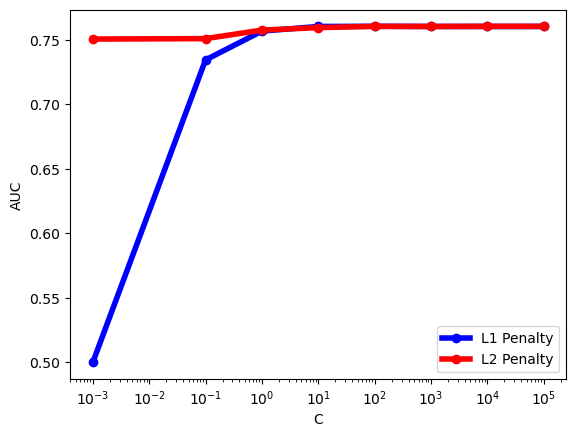

In [44]:
val_aucs_l1 = [val_aucs[i] for i in range(len(val_aucs)) if parameters[i]['penalty']=="l1"]
val_aucs_l2 = [val_aucs[i] for i in range(len(val_aucs)) if parameters[i]['penalty']=="l2"]
C_values = [parameters[i]['C'] for i in range(len(parameters)) if parameters[i]['penalty']=="l2"]

fig, ax = plt.subplots()
ax.semilogx( C_values, val_aucs_l1, marker='.', markerfacecolor='blue', markersize=12, color='blue', linewidth=4, label='L1 Penalty')
ax.semilogx( C_values, val_aucs_l2, marker='.', markerfacecolor='red', markersize=12, color='red', linewidth=4, label='L2 Penalty')
ax.set_xlabel("C")
ax.set_ylabel("AUC")
plt.legend()
plt.show()

~~**TODO: From the plot above, interpret why the hyperparameters were chosen as such.**~~

Before we do this, we first need to understand what the hyperparameters are, and how we're choosing the "best" model. We are working with two parameters here - the penalty term (L1, L2), and the C value. 

From the sklearn documentation - C values are the inverse of regularization that constrain a Logistic Regression model. Large C values give a model more freedom to shape the decision boundary to fit more datapoints. Th inverse is true regarding smaller C values. At the smallest C value, the L1 penalty results in a sparser solution due to the lack of freedom. We'll note that the L2 penalty shows only marginal improvement across all C values, while L1 penalty shows significant improvement up until C=100. If we compare both, by AUC - then the L1 penalty has a slightly better AUC fit than that of the L2 penalty. 

If we take note the tuning function two cells above this; we are evaluating the "best" model based on the global maximum of all our AUC results, which in this case is the L1 penalty with a C of 100.

#### 4.7. Interpreting the predictive accuracy

Until now, we used the predictive accuracy of the logistic regression model, which refers to the concordance between an individual's credit risk and the label assigned to that individual by the model. For instance, how often did the model predict that a person was a "bad credit risk" and that person in fact defaulted on a loan? 

We can think of this in terms of a 2x2 table (also called a *confusion matrix*):

|      | Did not default | Defaulted   |
| :---        |    :----:   |          ---: |
| **Labeled bad credit risk**  | A       | B   |
| **Labeled good credit risk**   | C       | D      |

Remember that in our dataset, "1" (or, positive) represents "good credit risk" and "0" (or, negative) represents "bad credit risk".

~~**TODO: What are the generic terms for A and D and what do they represent?**~~

I'll recreate the table according to our own data in this notebook:

|      | Did not default |  Defaulted   |
| :---        |    :----:   |          ---: |
| 0: Bad credit | False Negative       | True Negative   |
| 1: Good credit | True Positve       | False Positive      |


So A would be a False Negative, and D would be a False Positive.

**TODO: Based on this confusion matrix, input the number of true positives, false positives, true negatives, and false negatives:**

In [45]:
from sklearn.metrics import confusion_matrix

# Fit the model using the training data
best_lr = LogisticRegression(C=100, penalty="l1", solver='liblinear')
best_lr = best_lr.fit(x_train, y_train, sample_weight=None)

# Evaluate on validation set
accuracy, auc = evaluate(best_lr, x_val, y_val)
print("Accuracy: ", accuracy)
print("AUC: ", auc)

# Predict and evaluate on test set, we'll generate the confusion matrix on y_test, since that's what we're supposed to do
y_pred = best_lr.predict(x_test)

accuracy, auc = evaluate(best_lr, x_test, y_test)
print("Accuracy: ", accuracy)
print("AUC: ", auc)

Accuracy:  0.72
AUC:  0.7604084838963079
Accuracy:  0.77
AUC:  0.8148667601683031


In [ ]:
# the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 34  28]
 [ 18 120]]


In [69]:
# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.55      0.60        62
           1       0.81      0.87      0.84       138

    accuracy                           0.77       200
   macro avg       0.73      0.71      0.72       200
weighted avg       0.76      0.77      0.76       200



In [49]:
# This is from sklearn documentation
true_negative, false_positive, false_negative, true_positive = cm.ravel().tolist()
print(f'True Negatives: {true_negative}\n False Negatives: {false_negative}\n True Positives: {true_positive}\n False Positives: {false_positive}')

True Negatives: 34
 False Negatives: 18
 True Positives: 120
 False Positives: 28


Calculate the false positive rate:



In [52]:
# write code to calculate the false positive rate for all applicants
# in this code cell

fpr = round(false_positive / (false_positive + true_negative),3)
print('False Positive Rate:', fpr)

False Positive Rate: 0.452


Calculate the false *negative* rate:

In [53]:
# write code to calculate the false negative rate for all applicants
# in this code cell

fnr = round(false_negative / (true_positive + false_negative),3)
print('False Negative Rate:', fnr)

False Negative Rate: 0.13


~~**TODO: Take a moment to review the false positive rate and false negative rate above. For this application, comment on whether one metric is more desired over another?**~~

Lets go back to our confusion matrix for a second and summarize what our false positives and false negatives actually mean in context of the dataset, and by extension the business problem first.

|      | Did not default |  Defaulted   |
| :---        |    :----:   |          ---: |
| 0: Bad credit | False Negative       | True Negative   |
| 1: Good credit | True Positve       | False Positive      |

A False Positive would imply that our algorithm predicted that a customer had good credit, when reality they defaulted; which translates to approving a high risk customer. On the other hand, a False Negative would imply that our algorithm predicted a customer had bad credit when they did not default in the past, translating to rejecting a safe customer. 

Consequently, I think the FPR would be more desirable over the other. With a rate of 45%, this might become an issue for the business if ever implemented - since the model is tending towards approving customers that might not be able to repay loan amounts. This will largely come down to the skew we found in our data.

#### 4.8. Now, let's try another popular machine learning model, a Random Forest Classifier. You only need to change step 4.4 above, evaluate the trained random forest and compute the statistics as in step 4.7. You may also use hyperparameter tuning and compare the best random forest classifier with the best logistic regression classifier.

~~**TODO: Compare your results (accuracy and AUC) for the two models and comment on the similarities and differences in their performances.**~~

In [ ]:
# I'll just do this in one cell instead of re-running the old ones, making use of the previous functions
# This should cover both steps 4.4 and 4.7.
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


# This function will train, cross validate, fit and predict results on a small random forest model given hardcoded parameters. The intent is to make the model as small as possible
# It uses a grid search to find the best estimator, fits, and predicts on the test set in one go.
def random_forestPipe(X,Y, X_test, Y_test):

    base_rf = RandomForestClassifier(random_state=10)

    # parameter grid from documentation
    params = {'n_estimators': [100, 200, 350, 500],
              'criterion': ['gini', 'entropy', 'log_loss'],
              'max_depth': [None, 2, 4],
              'min_samples_split': [2,5,10],
              'min_samples_leaf': [1,5,7],
              'max_features': ['sqrt', 'log2', None]
              }
    
    search = GridSearchCV(estimator=base_rf, param_grid=params, cv=5, n_jobs=-1, scoring='roc_auc')
    search.fit(X,Y)

    best_rf = search.best_estimator_

    # I'm hard-coding the validation set here, and using the evaluate function

    accuracy, auc = evaluate(best_rf, x_val, y_val)
    print("Validation Accuracy: ", accuracy)
    print("Validation AUC: ", auc)

    # Now the test set
    y_pred = best_rf.predict(X_test)

    accuracy, auc = evaluate(best_rf, X_test, Y_test)

    cm = confusion_matrix(Y_test, y_pred)
    true_negative, false_positive, false_negative, true_positive = cm.ravel().tolist()

    print(f'Accuracy on test data: {accuracy}\n AUC on test data: {auc}')
    print(f'\nTrue Negatives: {true_negative}\n False Negatives: {false_negative}\n True Positives: {true_positive}\n False Positives: {false_positive}')
    print(classification_report(Y_test, y_pred))

In [73]:
random_forestPipe(X=x_train, Y=y_train, X_test=x_test, Y_test=y_test)

Validation Accuracy:  0.715
Validation AUC:  0.7774660531926831
Accuracy on test data: 0.775
 AUC on test data: 0.8032374941561478

True Negatives: 31
 False Negatives: 14
 True Positives: 124
 False Positives: 31
              precision    recall  f1-score   support

           0       0.69      0.50      0.58        62
           1       0.80      0.90      0.85       138

    accuracy                           0.78       200
   macro avg       0.74      0.70      0.71       200
weighted avg       0.77      0.78      0.76       200



## Observations

| Model | AUC | Accuracy | Runtime |
| --- | --- | --- | --- | 
| LogReg | 0.81 | 0.77 | < 1m | 
| RandomForest | 0.80 | 0.77 | 4.5m |

The Logistic Regression model is marginally better than the Random Forest model if we consider time to train, and go solely on the AUC score. Both models have similar accuracies on the data. Interestingly, the confusion matrix is somewhat similar - with the only difference being that the Random Forest model may be more biased towards approving high risk applicants for loans due to its slightly higher False Positives when compared to the Logistic Regression model. 